This experiment evaluates the evolution of the error as the number of graphs to be inferred increases. It compares the performance of independently identifying K similar graphs with respect the performance of a joint inference algorithm. 

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

import time
from joblib import Parallel, delayed
from os import cpu_count

import utils
import opt

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)

### Auxiliary functions

In [2]:
def sep_inf_Apsd(Co, regs):
    O = Co.shape[0]

    rho1 = regs['rho1']
    beta1 = regs['beta1']

    S_hat = cp.Variable((O, O), PSD=True)
    P_hat = cp.Variable((O, O), PSD=True)

    contraints = [S_hat >= 0, cp.sum(S_hat[:,0]) == 1]
    non_diag = ~np.eye(O, dtype=bool)

    obj = cp.trace((S_hat - P_hat)@Co) - cp.log_det(S_hat - P_hat) \
          + rho1*cp.norm(S_hat[non_diag], 1) + beta1*cp.norm(P_hat, 'nuc')


    prob = cp.Problem(cp.Minimize(obj), contraints)
    prob.solve()
    if prob.status not in ['optimal', 'optimal_inaccurate']:
        print('WARNING: problem status', prob.status)
        return np.zeros(S_hat.shape), np.zeros(S_hat.shape)

    return S_hat.value, P_hat.value


def plot_err(KK, err, ylab, logy=True, ylim=[]):
    plt.figure()
    if logy:
        plt.semilogy(KK, err[:,0], 'o:', linewidth=2, markersize=12, label='GL')
        plt.semilogy(KK, err[:,1], 'o-.', linewidth=2, markersize=12, label='GGL')
        plt.semilogy(KK, err[:,2], 'o-', linewidth=2, markersize=12, label='LVGL')
        plt.semilogy(KK, err[:,3], 'o--', linewidth=2, markersize=12, label='Joint Hidden')
    else:
        plt.plot(KK, err[:,0], 'o:', linewidth=2, markersize=12, label='GL')
        plt.plot(KK, err[:,1], 'o-.', linewidth=2, markersize=12, label='GGL')
        plt.plot(KK, err[:,2], 'o-', linewidth=2, markersize=12, label='LVGL')
        plt.plot(KK, err[:,3], 'o--', linewidth=2, markersize=12, label='Joint Hidden')

    plt.grid(True)
    plt.xlabel('Number of graphs')
    plt.ylabel(ylab)
    plt.legend()
    plt.xlim([KK[0], KK[-1]])
    if ylim:
        plt.ylim(ylim)
    plt.tight_layout()


def run_exp(id, KK, N, O, p, M, pert_links, regs):
    regs_no_h = regs.copy()
    regs_no_h['beta1'] = 1e3
    regs_no_h['beta2'] = 0
    
    # Create graphs
    A = np.zeros((N,N))
    tries = 0
    while np.any(np.sum(A,axis=1) == 0) and tries < 10:
        tries += 1
        A = nx.to_numpy_array(nx.erdos_renyi_graph(N, p))

    assert not np.any(np.sum(A,axis=1) == 0), 'Graphs with nodes with degree 0'

    As = utils.gen_similar_graphs(A, KK[-1], pert_links)
    
    # Fix scale
    As = As/np.sum(As[0,1:,0])

    _, Cs_hat = utils.create_GMRF_data(As, M)

    # Randomly select observed/hidden nodes
    rand_idx = np.random.permutation(np.arange(N))
    idx_o = rand_idx[:O]
    
    Aos = As[:,idx_o,:][:,:,idx_o]
    Cos_hat = Cs_hat[:,idx_o,:][:,:,idx_o]

    diag_idx = np.eye(O, dtype=bool)
    err = np.zeros((len(KK), 4))
    err_mean_norm = np.zeros((len(KK), 4))
    err_sum_norm = np.zeros((len(KK), 4))
    for i, K in enumerate(KK):
        Cok_hat = Cos_hat[:K,:,:]
        
        S_ggl, _ = opt.joint_inf_Apsd(Cok_hat, regs_no_h)
        S_joint, _ = opt.joint_inf_Apsd(Cok_hat, regs)

        norm_Ao_sq = 0
        S_lvgl = np.zeros(Cok_hat.shape)
        S_sep_noh = np.zeros(Cok_hat.shape)
        errs_aux = np.zeros(4)
        for k in range(K):
            norm_Aok = np.linalg.norm(Aos[k,:,:], 'fro')
            norm_Ao_sq += norm_Aok**2
            S_lvgl[k,:,:], _ = sep_inf_Apsd(Cok_hat[k,:,:], regs)
            S_sep_noh[k,:,:], _ = sep_inf_Apsd(Cok_hat[k,:,:], regs_no_h)

            # Set diags to 0
            S_sep_noh[k,:,:][diag_idx] = 0
            S_ggl[k,:,:][diag_idx] = 0
            S_lvgl[k,:,:][diag_idx] = 0
            S_joint[k,:,:][diag_idx] = 0
            
            # Errs
            errs_aux[0] = np.linalg.norm(S_sep_noh[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[1] = np.linalg.norm(S_ggl[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[2] = np.linalg.norm(S_lvgl[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[3] = np.linalg.norm(S_joint[k,:,:] - Aos[k,:,:], 'fro')**2

            # Compute errors
            err[i,:] += errs_aux
            err_mean_norm[i,:] += errs_aux/norm_Aok**2/K

        err_sum_norm[i,:] = err[i,:]/norm_Ao_sq

        print('{}-{}: Err LVGL: {:.4f} - Err joint: {:.4f}'.format(id, K, err_mean_norm[i,2], err_mean_norm[i,3]))

    # return err_sep, err_joint, err_sep_norm, err_joint_norm
    return err, err_mean_norm, err_sum_norm

In [3]:
# Experiment parameters
KK = [1, 2, 3, 4, 5, 6]
N = 20
O = 19
p = .15
M = 200
pert_links = 5
n_graphs = 25
regs = {'rho1': .01, 'rho2': .01, 'beta1': .1, 'beta2': .1}

# (K=1) Min mean err (rho1: 0.01, rho2: 0, beta1: 0.1, beta2: 0): 0.1466
# (K=3) Min mean err (rho1: 0.01, rho2: 0.01, beta1: 0.1, beta2: 0.01): 0.1072
# (K=3) Min mean err (rho1: 0.01, rho2: 0.01, beta1: 0.1, beta2: 0.01): 0.0871
# (K=5) Min mean err (rho1: 0.01, rho2: 0.01, beta1: 0.1, beta2: 0.1): 0.0814
# (K=7) Min mean err (rho1: 0.01, rho2: 0.01, beta1: 0.1, beta2: 0.1): 0.0689

err = np.zeros((len(KK), 4, n_graphs))
err_mean_norm = np.zeros((len(KK), 4, n_graphs))
err_sum_norm = np.zeros((len(KK), 4, n_graphs))

total_t = time.time()
print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, KK, N, O, p, M, pert_links, regs) for i in range(n_graphs))
for i, resp in enumerate(resps):
    err[:,:,i], err_mean_norm[:,:,i], err_sum_norm[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')


N_CPUS: 12


In [ ]:
# file = 'results/exp1'
# data = {'err': err, 'err_mean_norm': err_mean_norm, 'err_sum_norm': err_sum_norm}
# np.save(file, err)

In [ ]:
# err_mean_norm_mean_OLD = err_mean_norm_mean
# np.arange(1, KK[-1]+1)


# for i in range(KK[-1]):
#     err_mean_norm_mean[i,:] /= KK[i]

[[ 6.41836481  4.10286941  2.87063288  2.07375911]
 [12.99166586 12.73756899  5.83339608  3.04311257]
 [18.49196807 26.35812313  8.77367522  3.85302545]
 [24.99314303 38.28142898 11.74959438  4.63872002]
 [27.92455606 45.26911258 14.8893643   5.83786427]
 [30.55532957 70.10684202 17.75309417  7.15075016]]
[[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[[0.27632495 0.2492835  0.24601132 0.19722201]
 [0.27884771 0.31769668 0.24304783 0.13884185]
 [0.2751596  0.39954372 0.2403669  0.10729343]
 [0.27500168 0.49670973 0.24375777 0.08879074]
 [0.26473334 0.53519553 0.24343749 0.07988324]
 [0.25723181 0.63697289 0.24227925 0.07502834]]


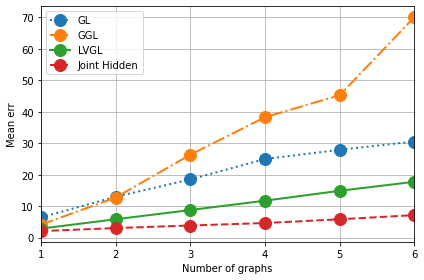

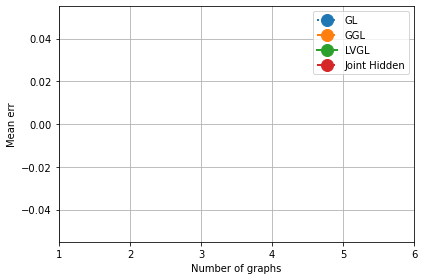

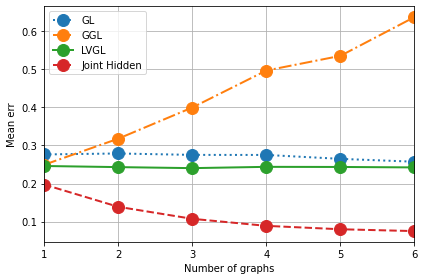

In [ ]:
# %matplotlib qt
err_mean = np.mean(err, axis=2)
err_mean_norm_mean = np.mean(err_mean_norm, axis=2)
err_sum_norm_mean = np.mean(err_sum_norm, axis=2)

print(err_mean)
print(err_mean_norm_mean)
print(err_sum_norm_mean)

plot_err(KK, err_mean, 'Mean err', logy=False)
plot_err(KK, err_mean_norm_mean, 'Mean err', logy=False)
plot_err(KK, err_sum_norm_mean, 'Mean err', logy=False)

[[ 6.41836481  4.10286941  2.87063288  2.07375911]
 [12.99166586 12.73756899  5.83339608  3.04311257]
 [18.49196807 26.35812313  8.77367522  3.85302545]
 [24.99314303 38.28142898 11.74959438  4.63872002]
 [27.92455606 45.26911258 14.8893643   5.83786427]
 [30.55532957 70.10684202 17.75309417  7.15075016]]
[[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[[0.27632495 0.2492835  0.24601132 0.19722201]
 [0.27884771 0.31769668 0.24304783 0.13884185]
 [0.2751596  0.39954372 0.2403669  0.10729343]
 [0.27500168 0.49670973 0.24375777 0.08879074]
 [0.26473334 0.53519553 0.24343749 0.07988324]
 [0.25723181 0.63697289 0.24227925 0.07502834]]


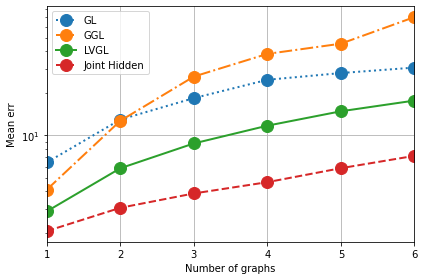

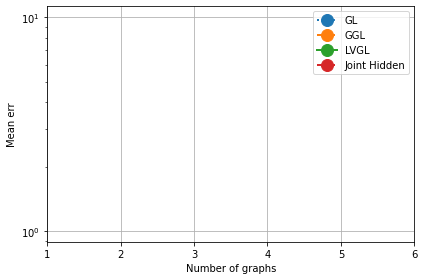

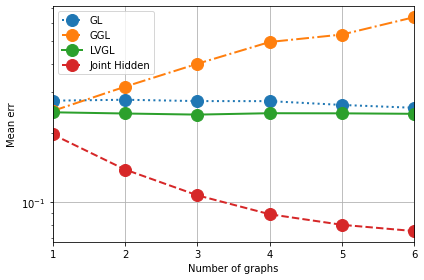

In [ ]:
err_mean = np.mean(err, axis=2)
err_mean_norm_mean = np.mean(err_mean_norm, axis=2)
err_sum_norm_mean = np.mean(err_sum_norm, axis=2)

print(err_mean)
print(err_mean_norm_mean)
print(err_sum_norm_mean)

plot_err(KK, err_mean, 'Mean err', logy=True)
plot_err(KK, err_mean_norm_mean, 'Mean err', logy=True)
plot_err(KK, err_sum_norm_mean, 'Mean err', logy=True)